# One Mouse through the pipeline

In [60]:
import numpy as np
import cv2
import pydicom as dicom
from matplotlib import pyplot as plt
from scipy.signal import argrelextrema

# Parameters to set outside of loops

In [64]:
# List of images to go through
SAX_img_0w =  ["imgs/995/SAX_0w_cut/frame"]
SAX_img_2w = ["imgs/995/SAX_2w_cut/frame"]
SAX_frames =  [21, 42]

PSLA_img_0w = ["imgs/995/PSLA_0w_cut/frame"]
PSLA_img_2w = ["imgs/995/PSLA_2w_cut/frame"]
PSLA_frames =  [21, 42, 63]

max_scale_PSLA = 9.9
min_scale_PSLA = 1.1

max_scale_SAX = 10.9
min_scale_SAX = 2.1

HR = 313

## Functions

In [65]:
# Link: https://www.geeksforgeeks.org/longest-sequence-positive-integers-array/

def getLongestSeq_black(a, n):
    maxIdx = 0
    maxLen = 0
    currLen = 0
    currIdx = 0
    for k in range(n):
        if a[k] < 15:
            currLen += 1
            if currLen == 1:
                currIdx = k
        else:
            if currLen > maxLen:
                maxLen = currLen
                maxIdx = currIdx
            currLen = 0
 
    if currLen > maxLen:
        maxLen = currLen
        maxIdx = currIdx
 
    if maxLen > 0:
        return maxIdx, maxLen
    else:
        return 0,0 

def getLongestSeq_white(a, n):
    maxIdx = 0
    maxLen = 0
    currLen = 0
    currIdx = 0
    for k in range(n):
        if a[k] > 240:
            currLen += 1
            if currLen == 1:
                currIdx = k
        else:
            if currLen > maxLen:
                maxLen = currLen
                maxIdx = currIdx
            currLen = 0
 
    if currLen > maxLen:
        maxLen = currLen
        maxIdx = currIdx
 
    if maxLen > 0:
        return maxIdx, maxLen
    else:
        return 0,0


# Link: https://scipy-cookbook.readthedocs.io/items/SignalSmooth.html

def smooth(x,window_len=11,window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """
    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y[int((window_len-1)/2):-int((window_len-1)/2)]

In [66]:
# Parameter values to collect 0 weeks
LVESV_list = []
LVEDV_list = []
FS_list = [] 
EF_list = []
SV_list = []
CO_list = [] 
LV_mass_list = []

# Parameter values to collect 2 weeks
LVESV_list2 = []
LVEDV_list2 = []
FS_list2 = [] 
EF_list2 = []
SV_list2 = []
CO_list2 = [] 
LV_mass_list2 = []

# SAX images

### SAX 0 weeks 

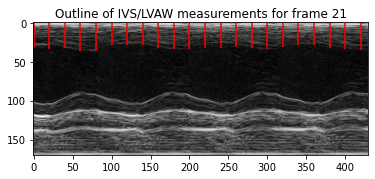

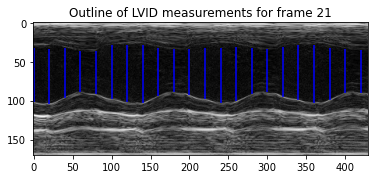

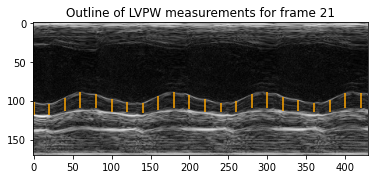

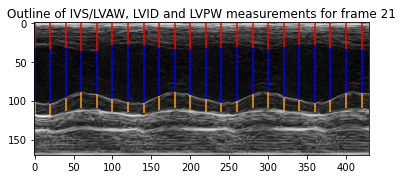

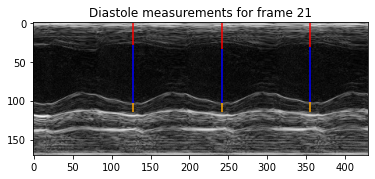

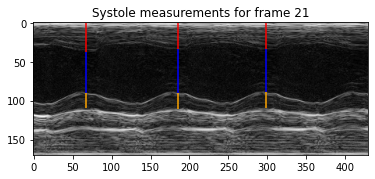

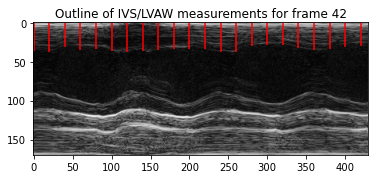

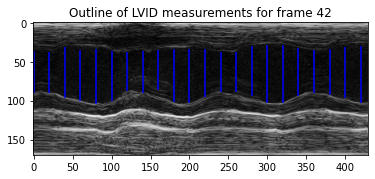

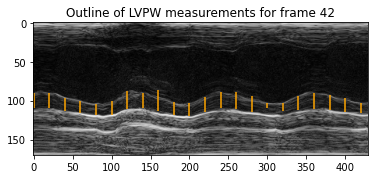

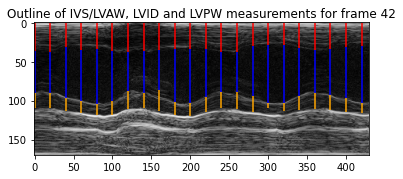

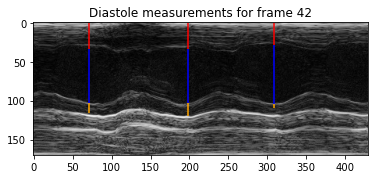

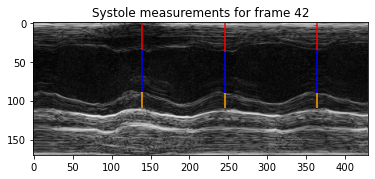

In [67]:

for path in SAX_img_0w:
    for frame_no in SAX_frames:
        full_path = path + str(frame_no) + ".jpg"
        img = cv2.imread(full_path, 0)
        implot = plt.imshow(img, cmap="gray")

        # Folder for results
        res_folder = path+ str(frame_no) + "/res/"

        # Create preprocessed images
        roof_img = path + str(frame_no) + str("/higher.png")
        tat_img = path  + str(frame_no) + str("/lower.png")
        floor_img = path + str(frame_no) + str("/medium.png")

        roof = cv2.imread(roof_img, 0)
        # plt.imshow(roof, cmap="gray")
        # plt.title("Isolating roof of LVID")
        # plt.show()

        tat = cv2.imread(tat_img, 0)
        # plt.imshow(tat, cmap="gray")
        # plt.title("Isolating boundary for LVPW")
        # plt.show()

        floor = cv2.imread(floor_img, 0)
        # plt.imshow(floor, cmap="gray")
        # plt.title("Isolating bottom of LVID")
        # plt.show()


        # Finding IVS, LVAW, LVID and LVPW distances

        start_LVID = []
        end_LVID = []
        start_LVPW = []

        for i in range(len(floor[0])):
            col_roof = roof[:,i]
            col_tat = tat[:,i]
            col_floor = floor[:,i]

            n_ = len(col_roof)

            end,_ = getLongestSeq_black(col_roof, n_)
            end_LVID.append(end)

            _, start2 = getLongestSeq_white(col_tat, n_) 
            start_LVPW.append(start2)
            
            _,start = getLongestSeq_white(col_floor, n_)
            start_LVID.append(start)

        plt.imshow(img, cmap="gray")
        for i in range(0,len(start_LVID),20):
            #IVS/LVAW
            plt.vlines(i, end_LVID[i], 0, colors="red")
        plt.title("Outline of IVS/LVAW measurements for frame {}".format(frame_no))
        plt.savefig(res_folder + "outline_0w_IVS_LVAW_{}.png".format(frame_no))
        plt.show()

        plt.imshow(img, cmap="gray")
        for i in range(0,len(start_LVID),20):
            #LVID
            plt.vlines(i, end_LVID[i], start_LVID[i], colors="blue")
        plt.title("Outline of LVID measurements for frame {}".format(frame_no))
        plt.savefig(res_folder + "outline_0w_LVID_{}.png".format(frame_no))
        plt.show()

        plt.imshow(img, cmap="gray")
        for i in range(0,len(start_LVID),20):
            #LVPW
            plt.vlines(i, start_LVID[i], start_LVPW[i], colors="orange")
        plt.title("Outline of LVPW measurements for frame {}".format(frame_no))
        plt.savefig(res_folder + "outline_0w_LVPW_{}.png".format(frame_no))
        plt.show()

        plt.imshow(img, cmap="gray")
        for i in range(0,len(start_LVID),20):
            #IVS/LVAW
            plt.vlines(i, end_LVID[i], 0, colors="red")
            #LVID
            plt.vlines(i, end_LVID[i], start_LVID[i], colors="blue")
            #LVPW
            plt.vlines(i, start_LVID[i], start_LVPW[i], colors="orange")
        plt.title("Outline of IVS/LVAW, LVID and LVPW measurements for frame {}".format(frame_no))
        plt.savefig(res_folder + "outline_0w_{}.png".format(frame_no))
        plt.show()

        IVS_LVAW = np.array(end_LVID)
        LVID = np.array(start_LVID) - np.array(end_LVID)  
        LVPW = np.array(start_LVPW) - np.array(start_LVID)

        # Identifying diastole and systole


        LVID_diastole = []
        LVID_systole = []

        IVS_LVAW_diastole = []
        IVS_LVAW_systole = []

        LVPW_diastole = []
        LVPW_systole = []

        LVID_smooth = smooth(LVID,155,"blackman")


        ### Diastole
        plt.imshow(img, cmap="gray")
        for i in list(argrelextrema(LVID_smooth, np.greater)[0]):

            if end_LVID[i] > 0 and start_LVPW[i] > 0:
                # Saving the values
                LVID_diastole.append(start_LVID[i]-end_LVID[i])
                IVS_LVAW_diastole.append(end_LVID[i])
                LVPW_diastole.append(start_LVPW[i] - start_LVID[i])

                #IVS/LVAW
                plt.vlines(i, end_LVID[i], 0, colors="red")
                #LVID
                plt.vlines(i, end_LVID[i], start_LVID[i], colors="blue")
                #LVPW
                plt.vlines(i, start_LVID[i], start_LVPW[i], colors="orange")
        plt.title("Diastole measurements for frame {}".format(frame_no))
        plt.savefig(res_folder + "diastole_0w_{}.png".format(frame_no))
        plt.show()
        

        ### Systole
        plt.imshow(img, cmap="gray")
        for i in list(argrelextrema(LVID_smooth, np.less)[0]):
            if end_LVID[i] > 0 and start_LVPW[i] > 0:
                # Saving the values that pass the filter
                LVID_systole.append(start_LVID[i]-end_LVID[i])
                IVS_LVAW_systole.append(end_LVID[i])
                LVPW_systole.append(start_LVPW[i] - start_LVID[i])

                #IVS/LVAW
                plt.vlines(i, end_LVID[i], 0, colors="red")
                #LVID
                plt.vlines(i, end_LVID[i], start_LVID[i], colors="blue")
                #LVPW
                plt.vlines(i, start_LVID[i], start_LVPW[i], colors="orange")
        plt.title("Systole measurements for frame {}".format(frame_no))
        plt.savefig(res_folder + "systole_0w_{}.png".format(frame_no))
        plt.show()
        

        # Inferring length of walls from scale

        # The scale in the image goes from 2.8 to 10.9 so the whole scale is:
        full_length = max_scale_SAX-min_scale_SAX

        # We divide this by the number of pixels in a column,
        # so we can convert from pixel stretch to actual measurement
        one_pixel_length = full_length/len(img[:,0])


        # Actual measurements of IVS/LVAW, LVID and LVPW
        LVID_diastole_real = np.array(LVID_diastole)  * one_pixel_length 
        LVID_systole_real = np.array(LVID_systole) * one_pixel_length

        IVS_LVAW_diastole_real = np.array(IVS_LVAW_diastole) * one_pixel_length
        IVS_LVAW_systole_real = np.array(IVS_LVAW_systole) * one_pixel_length

        LVPW_diastole_real = np.array(LVPW_diastole) * one_pixel_length
        LVPW_systole_real = np.array(LVPW_systole) * one_pixel_length


        # Average measurements
        LVID_d = np.mean(LVID_diastole_real)
        LVID_s = np.mean(LVID_systole_real)

        IVS_LVAW_d = np.mean(IVS_LVAW_diastole_real)
        IVS_LVAW_s = np.mean(IVS_LVAW_systole_real)

        LVPW_d = np.mean(LVPW_diastole_real)
        LVPW_s = np.mean(LVPW_systole_real)

        # Calculating parameters

        LVESV = (7/(2.4+LVID_s))*LVID_s**3
        LVEDV = (7/(2.4+LVID_d))*LVID_d**3

        FS = ((LVID_d - LVID_s)/LVID_d)*100
        EF = ((LVEDV-LVESV)/LVEDV)*100

        SV = LVEDV - LVESV
        CO = SV*HR

        # Only for SAX images
        LV_mass = 1.04*(((LVID_d+IVS_LVAW_d+LVPW_d)**3)-(LVID_d**3))*0.8+0.6

        LVESV_list.append(LVESV)
        LVEDV_list.append(LVEDV)
        FS_list.append(FS) 
        EF_list.append(EF)
        SV_list.append(SV)
        CO_list.append(CO) 
        LV_mass_list.append(LV_mass)

    

### SAX 2 weeks

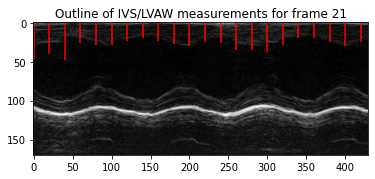

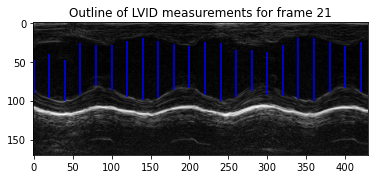

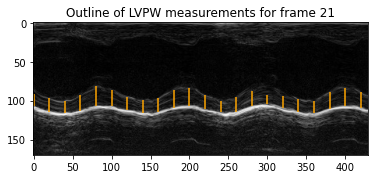

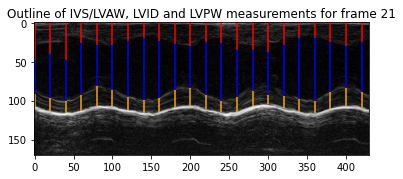

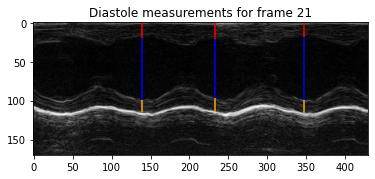

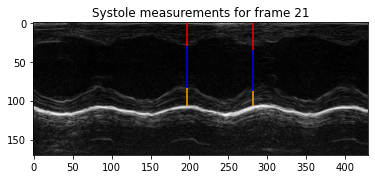

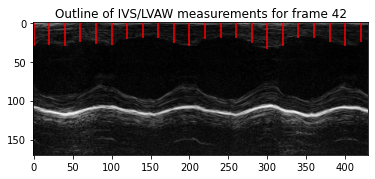

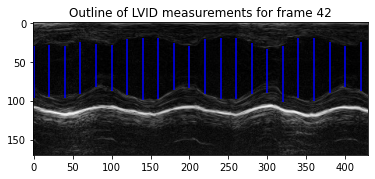

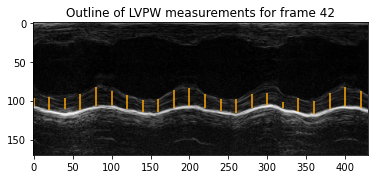

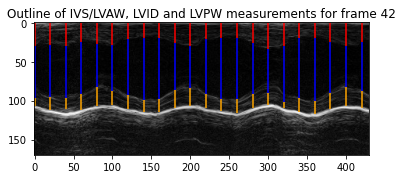

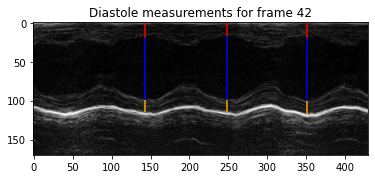

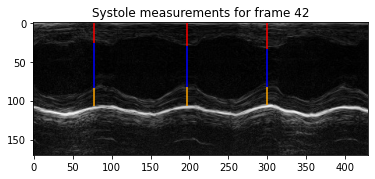

In [68]:

for path in SAX_img_2w:
    for frame_no in SAX_frames:
        full_path = path + str(frame_no) + ".jpg"
        img = cv2.imread(full_path, 0)
        implot = plt.imshow(img, cmap="gray")

        # Folder for results
        res_folder = path+ str(frame_no) + "/res/"

        # Create preprocessed images
        roof_img = path + str(frame_no) + str("/higher.png")
        tat_img = path  + str(frame_no) + str("/lower.png")
        floor_img = path + str(frame_no) + str("/medium.png")

        roof = cv2.imread(roof_img, 0)
        # plt.imshow(roof, cmap="gray")
        # plt.title("Isolating roof of LVID")
        # plt.show()

        tat = cv2.imread(tat_img, 0)
        # plt.imshow(tat, cmap="gray")
        # plt.title("Isolating boundary for LVPW")
        # plt.show()

        floor = cv2.imread(floor_img, 0)
        # plt.imshow(floor, cmap="gray")
        # plt.title("Isolating bottom of LVID")
        # plt.show()


        # Finding IVS, LVAW, LVID and LVPW distances

        start_LVID = []
        end_LVID = []
        start_LVPW = []

        for i in range(len(floor[0])):
            col_roof = roof[:,i]
            col_tat = tat[:,i]
            col_floor = floor[:,i]

            n_ = len(col_roof)

            end,_ = getLongestSeq_black(col_roof, n_)
            end_LVID.append(end)

            _, start2 = getLongestSeq_white(col_tat, n_) 
            start_LVPW.append(start2)
            
            _,start = getLongestSeq_white(col_floor, n_)
            start_LVID.append(start)

        plt.imshow(img, cmap="gray")
        for i in range(0,len(start_LVID),20):
            #IVS/LVAW
            plt.vlines(i, end_LVID[i], 0, colors="red")
        plt.title("Outline of IVS/LVAW measurements for frame {}".format(frame_no))
        plt.savefig(res_folder + "outline_2w_IVS_LVAW_{}.png".format(frame_no))
        plt.show()

        plt.imshow(img, cmap="gray")
        for i in range(0,len(start_LVID),20):
            #LVID
            plt.vlines(i, end_LVID[i], start_LVID[i], colors="blue")
        plt.title("Outline of LVID measurements for frame {}".format(frame_no))
        plt.savefig(res_folder + "outline_2w_LVID_{}.png".format(frame_no))
        plt.show()

        plt.imshow(img, cmap="gray")
        for i in range(0,len(start_LVID),20):
            #LVPW
            plt.vlines(i, start_LVID[i], start_LVPW[i], colors="orange")
        plt.title("Outline of LVPW measurements for frame {}".format(frame_no))
        plt.savefig(res_folder + "outline_2w_LVPW_{}.png".format(frame_no))
        plt.show()

        plt.imshow(img, cmap="gray")
        for i in range(0,len(start_LVID),20):
            #IVS/LVAW
            plt.vlines(i, end_LVID[i], 0, colors="red")
            #LVID
            plt.vlines(i, end_LVID[i], start_LVID[i], colors="blue")
            #LVPW
            plt.vlines(i, start_LVID[i], start_LVPW[i], colors="orange")
        plt.title("Outline of IVS/LVAW, LVID and LVPW measurements for frame {}".format(frame_no))
        plt.savefig(res_folder + "outline_2w_{}.png".format(frame_no))
        plt.show()

        IVS_LVAW = np.array(end_LVID)
        LVID = np.array(start_LVID) - np.array(end_LVID)  
        LVPW = np.array(start_LVPW) - np.array(start_LVID)

        # Identifying diastole and systole


        LVID_diastole = []
        LVID_systole = []

        IVS_LVAW_diastole = []
        IVS_LVAW_systole = []

        LVPW_diastole = []
        LVPW_systole = []

        LVID_smooth = smooth(LVID,155,"blackman")


        ### Diastole
        plt.imshow(img, cmap="gray")
        for i in list(argrelextrema(LVID_smooth, np.greater)[0]):

            if end_LVID[i] > 0 and start_LVPW[i] > 0:
                # Saving the values
                LVID_diastole.append(start_LVID[i]-end_LVID[i])
                IVS_LVAW_diastole.append(end_LVID[i])
                LVPW_diastole.append(start_LVPW[i] - start_LVID[i])

                #IVS/LVAW
                plt.vlines(i, end_LVID[i], 0, colors="red")
                #LVID
                plt.vlines(i, end_LVID[i], start_LVID[i], colors="blue")
                #LVPW
                plt.vlines(i, start_LVID[i], start_LVPW[i], colors="orange")
        plt.title("Diastole measurements for frame {}".format(frame_no))
        plt.savefig(res_folder + "diastole_2w_{}.png".format(frame_no))
        plt.show()
        

        ### Systole
        plt.imshow(img, cmap="gray")
        for i in list(argrelextrema(LVID_smooth, np.less)[0]):
            if end_LVID[i] > 0 and start_LVPW[i] > 0:
                # Saving the values that pass the filter
                LVID_systole.append(start_LVID[i]-end_LVID[i])
                IVS_LVAW_systole.append(end_LVID[i])
                LVPW_systole.append(start_LVPW[i] - start_LVID[i])

                #IVS/LVAW
                plt.vlines(i, end_LVID[i], 0, colors="red")
                #LVID
                plt.vlines(i, end_LVID[i], start_LVID[i], colors="blue")
                #LVPW
                plt.vlines(i, start_LVID[i], start_LVPW[i], colors="orange")
        plt.title("Systole measurements for frame {}".format(frame_no))
        plt.savefig(res_folder + "systole_2w_{}.png".format(frame_no))
        plt.show()
        

        # Inferring length of walls from scale

        # The scale in the image goes from 2.8 to 10.9 so the whole scale is:
        full_length = max_scale_SAX-min_scale_SAX

        # We divide this by the number of pixels in a column,
        # so we can convert from pixel stretch to actual measurement
        one_pixel_length = full_length/len(img[:,0])


        # Actual measurements of IVS/LVAW, LVID and LVPW
        LVID_diastole_real = np.array(LVID_diastole)  * one_pixel_length 
        LVID_systole_real = np.array(LVID_systole) * one_pixel_length

        IVS_LVAW_diastole_real = np.array(IVS_LVAW_diastole) * one_pixel_length
        IVS_LVAW_systole_real = np.array(IVS_LVAW_systole) * one_pixel_length

        LVPW_diastole_real = np.array(LVPW_diastole) * one_pixel_length
        LVPW_systole_real = np.array(LVPW_systole) * one_pixel_length


        # Average measurements
        LVID_d = np.mean(LVID_diastole_real)
        LVID_s = np.mean(LVID_systole_real)

        IVS_LVAW_d = np.mean(IVS_LVAW_diastole_real)
        IVS_LVAW_s = np.mean(IVS_LVAW_systole_real)

        LVPW_d = np.mean(LVPW_diastole_real)
        LVPW_s = np.mean(LVPW_systole_real)

        # Calculating parameters

        LVESV = (7/(2.4+LVID_s))*LVID_s**3
        LVEDV = (7/(2.4+LVID_d))*LVID_d**3

        FS = ((LVID_d - LVID_s)/LVID_d)*100
        EF = ((LVEDV-LVESV)/LVEDV)*100

        SV = LVEDV - LVESV
        CO = SV*HR

        # Only for SAX images
        LV_mass = 1.04*(((LVID_d+IVS_LVAW_d+LVPW_d)**3)-(LVID_d**3))*0.8+0.6

        LVESV_list2.append(LVESV)
        LVEDV_list2.append(LVEDV)
        FS_list2.append(FS) 
        EF_list2.append(EF)
        SV_list2.append(SV)
        CO_list2.append(CO) 
        LV_mass_list2.append(LV_mass)

    

# PSLA images

### PSLA 0 weeks

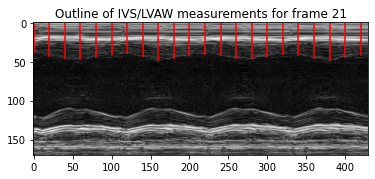

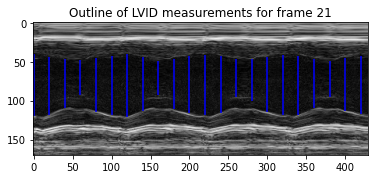

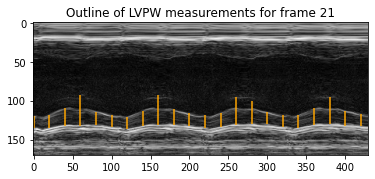

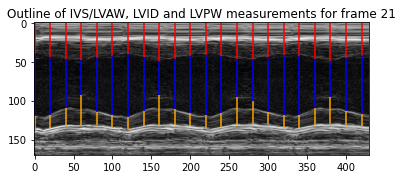

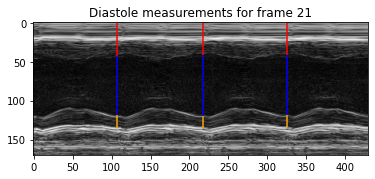

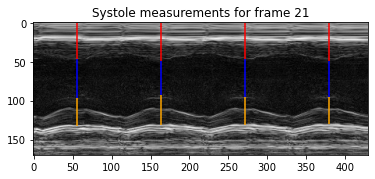

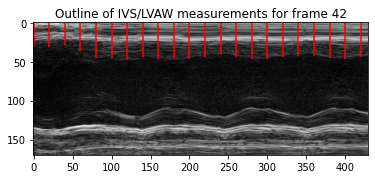

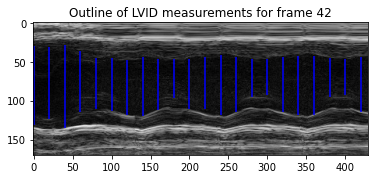

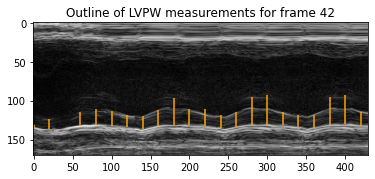

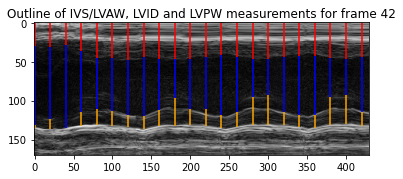

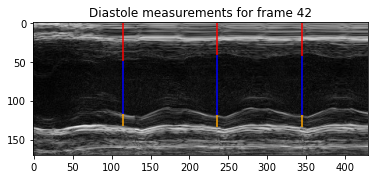

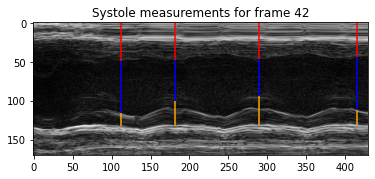

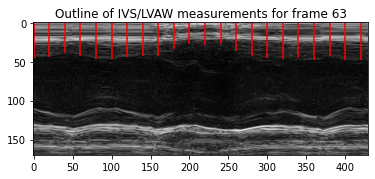

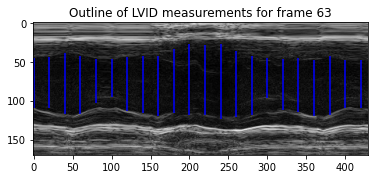

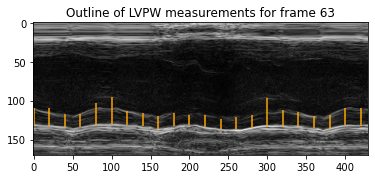

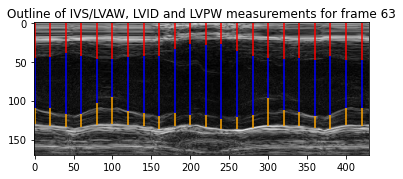

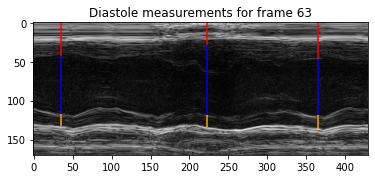

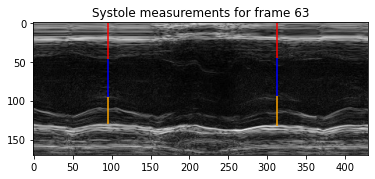

In [69]:


for path in PSLA_img_0w:
    for frame_no in PSLA_frames:
        full_path = path + str(frame_no) + ".jpg"
        img = cv2.imread(full_path, 0)
        implot = plt.imshow(img, cmap="gray")

        # Folder for results
        res_folder = path+ str(frame_no) + "/res/"

        # Create preprocessed images
        roof_img = path + str(frame_no) + str("/higher.png")
        tat_img = path  + str(frame_no) + str("/lower.png")
        floor_img = path + str(frame_no) + str("/medium.png")

        roof = cv2.imread(roof_img, 0)
        # plt.imshow(roof, cmap="gray")
        # plt.title("Isolating roof of LVID")
        # plt.show()

        tat = cv2.imread(tat_img, 0)
        # plt.imshow(tat, cmap="gray")
        # plt.title("Isolating boundary for LVPW")
        # plt.show()

        floor = cv2.imread(floor_img, 0)
        # plt.imshow(floor, cmap="gray")
        # plt.title("Isolating bottom of LVID")
        # plt.show()


        # Finding IVS, LVAW, LVID and LVPW distances

        start_LVID = []
        end_LVID = []
        start_LVPW = []

        for i in range(len(floor[0])):
            col_roof = roof[:,i]
            col_tat = tat[:,i]
            col_floor = floor[:,i]

            n_ = len(col_roof)

            end,_ = getLongestSeq_black(col_roof, n_)
            end_LVID.append(end)

            _, start2 = getLongestSeq_white(col_tat, n_) 
            start_LVPW.append(start2)
            
            _,start = getLongestSeq_white(col_floor, n_)
            start_LVID.append(start)


        plt.imshow(img, cmap="gray")
        for i in range(0,len(start_LVID),20):
            #IVS/LVAW
            plt.vlines(i, end_LVID[i], 0, colors="red")
        plt.title("Outline of IVS/LVAW measurements for frame {}".format(frame_no))
        plt.savefig(res_folder + "outline_0w_IVS_LVAW_{}.png".format(frame_no))
        plt.show()

        plt.imshow(img, cmap="gray")
        for i in range(0,len(start_LVID),20):
            #LVID
            plt.vlines(i, end_LVID[i], start_LVID[i], colors="blue")
        plt.title("Outline of LVID measurements for frame {}".format(frame_no))
        plt.savefig(res_folder + "outline_0w_LVID_{}.png".format(frame_no))
        plt.show()

        plt.imshow(img, cmap="gray")
        for i in range(0,len(start_LVID),20):
            #LVPW
            plt.vlines(i, start_LVID[i], start_LVPW[i], colors="orange")
        plt.title("Outline of LVPW measurements for frame {}".format(frame_no))
        plt.savefig(res_folder + "outline_0w_LVPW_{}.png".format(frame_no))
        plt.show()

        plt.imshow(img, cmap="gray")
        for i in range(0,len(start_LVID),20):
            #IVS/LVAW
            plt.vlines(i, end_LVID[i], 0, colors="red")
            #LVID
            plt.vlines(i, end_LVID[i], start_LVID[i], colors="blue")
            #LVPW
            plt.vlines(i, start_LVID[i], start_LVPW[i], colors="orange")
        plt.title("Outline of IVS/LVAW, LVID and LVPW measurements for frame {}".format(frame_no))
        plt.savefig(res_folder + "outline_0w_{}.png".format(frame_no))
        plt.show()

        IVS_LVAW = np.array(end_LVID)
        LVID = np.array(start_LVID) - np.array(end_LVID)  
        LVPW = np.array(start_LVPW) - np.array(start_LVID)

        # Identifying diastole and systole


        LVID_diastole = []
        LVID_systole = []

        IVS_LVAW_diastole = []
        IVS_LVAW_systole = []

        LVPW_diastole = []
        LVPW_systole = []

        LVID_smooth = smooth(LVID,155,"blackman")


        ### Diastole
        plt.imshow(img, cmap="gray")
        for i in list(argrelextrema(LVID_smooth, np.greater)[0]):

            if end_LVID[i] > 0 and start_LVPW[i] > 0:
                # Saving the values
                LVID_diastole.append(start_LVID[i]-end_LVID[i])
                IVS_LVAW_diastole.append(end_LVID[i])
                LVPW_diastole.append(start_LVPW[i] - start_LVID[i])

                #IVS/LVAW
                plt.vlines(i, end_LVID[i], 0, colors="red")
                #LVID
                plt.vlines(i, end_LVID[i], start_LVID[i], colors="blue")
                #LVPW
                plt.vlines(i, start_LVID[i], start_LVPW[i], colors="orange")
                plt.title("Diastole measurements")
        plt.title("Diastole measurements for frame {}".format(frame_no))
        plt.savefig(res_folder + "diastole_0w_{}.png".format(frame_no))
        plt.show()


        ### Systole
        plt.imshow(img, cmap="gray")
        for i in list(argrelextrema(LVID_smooth, np.less)[0]):
            if end_LVID[i] > 0 and start_LVPW[i] > 0:
                # Saving the values that pass the filter
                LVID_systole.append(start_LVID[i]-end_LVID[i])
                IVS_LVAW_systole.append(end_LVID[i])
                LVPW_systole.append(start_LVPW[i] - start_LVID[i])

                #IVS/LVAW
                plt.vlines(i, end_LVID[i], 0, colors="red")
                #LVID
                plt.vlines(i, end_LVID[i], start_LVID[i], colors="blue")
                #LVPW
                plt.vlines(i, start_LVID[i], start_LVPW[i], colors="orange")
                plt.title("Systole measurements")
        plt.title("Systole measurements for frame {}".format(frame_no))
        plt.savefig(res_folder + "systole_0w_{}.png".format(frame_no))
        plt.show()

        # Inferring length of walls from scale

        # The scale in the image goes from 2.8 to 10.9 so the whole scale is:
        full_length = max_scale_PSLA-min_scale_PSLA

        # We divide this by the number of pixels in a column,
        # so we can convert from pixel stretch to actual measurement
        one_pixel_length = full_length/len(img[:,0])


        # Actual measurements of IVS/LVAW, LVID and LVPW
        LVID_diastole_real = np.array(LVID_diastole)  * one_pixel_length 
        LVID_systole_real = np.array(LVID_systole) * one_pixel_length

        IVS_LVAW_diastole_real = np.array(IVS_LVAW_diastole) * one_pixel_length
        IVS_LVAW_systole_real = np.array(IVS_LVAW_systole) * one_pixel_length

        LVPW_diastole_real = np.array(LVPW_diastole) * one_pixel_length
        LVPW_systole_real = np.array(LVPW_systole) * one_pixel_length


        # Average measurements
        LVID_d = np.mean(LVID_diastole_real)
        LVID_s = np.mean(LVID_systole_real)

        IVS_LVAW_d = np.mean(IVS_LVAW_diastole_real)
        IVS_LVAW_s = np.mean(IVS_LVAW_systole_real)

        LVPW_d = np.mean(LVPW_diastole_real)
        LVPW_s = np.mean(LVPW_systole_real)

        # Calculating parameters

        LVESV = (7/(2.4+LVID_s))*LVID_s**3
        LVEDV = (7/(2.4+LVID_d))*LVID_d**3

        FS = ((LVID_d - LVID_s)/LVID_d)*100
        EF = ((LVEDV-LVESV)/LVEDV)*100

        SV = LVEDV - LVESV
        CO = SV*HR


        LVESV_list.append(LVESV)
        LVEDV_list.append(LVEDV)
        FS_list.append(FS) 
        EF_list.append(EF)
        SV_list.append(SV)
        CO_list.append(CO) 

    

### PSLA 2 weeks

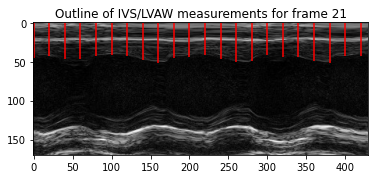

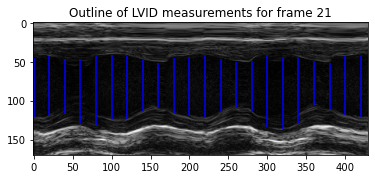

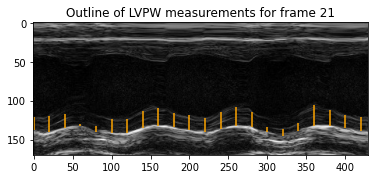

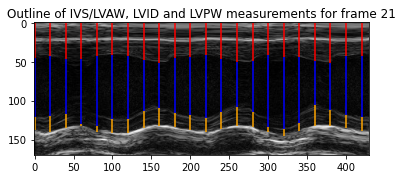

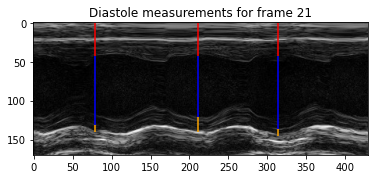

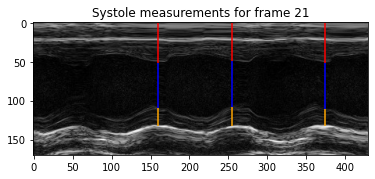

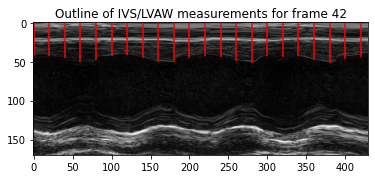

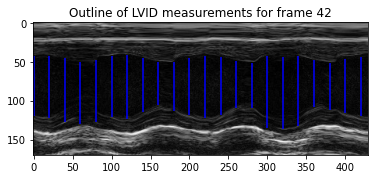

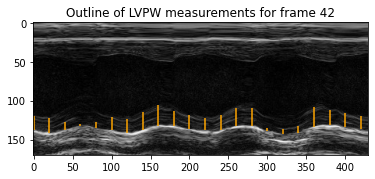

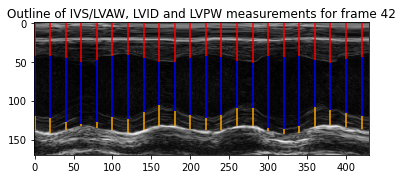

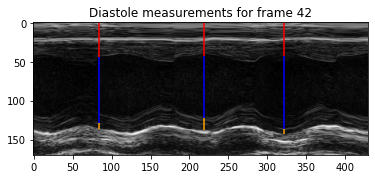

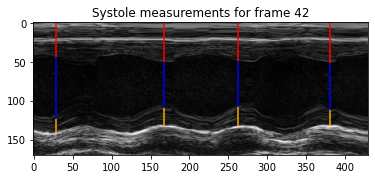

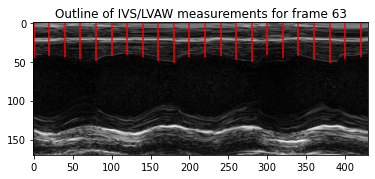

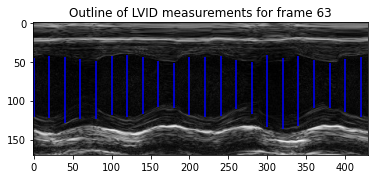

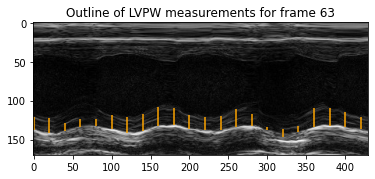

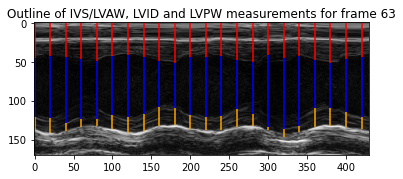

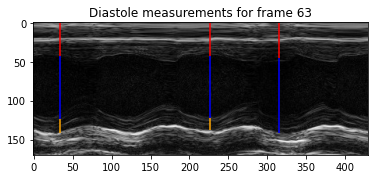

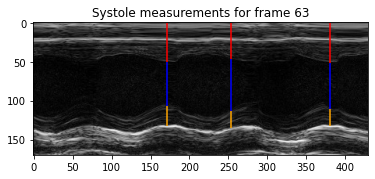

In [70]:


for path in PSLA_img_2w:
    for frame_no in PSLA_frames:
        full_path = path + str(frame_no) + ".jpg"
        img = cv2.imread(full_path, 0)
        implot = plt.imshow(img, cmap="gray")

        # Folder for results
        res_folder = path+ str(frame_no) + "/res/"

        # Create preprocessed images
        roof_img = path + str(frame_no) + str("/higher.png")
        tat_img = path  + str(frame_no) + str("/lower.png")
        floor_img = path + str(frame_no) + str("/medium.png")

        roof = cv2.imread(roof_img, 0)
        # plt.imshow(roof, cmap="gray")
        # plt.title("Isolating roof of LVID")
        # plt.show()

        tat = cv2.imread(tat_img, 0)
        # plt.imshow(tat, cmap="gray")
        # plt.title("Isolating boundary for LVPW")
        # plt.show()

        floor = cv2.imread(floor_img, 0)
        # plt.imshow(floor, cmap="gray")
        # plt.title("Isolating bottom of LVID")
        # plt.show()


        # Finding IVS, LVAW, LVID and LVPW distances

        start_LVID = []
        end_LVID = []
        start_LVPW = []

        for i in range(len(floor[0])):
            col_roof = roof[:,i]
            col_tat = tat[:,i]
            col_floor = floor[:,i]

            n_ = len(col_roof)

            end,_ = getLongestSeq_black(col_roof, n_)
            end_LVID.append(end)

            _, start2 = getLongestSeq_white(col_tat, n_) 
            start_LVPW.append(start2)
            
            _,start = getLongestSeq_white(col_floor, n_)
            start_LVID.append(start)


        plt.imshow(img, cmap="gray")
        for i in range(0,len(start_LVID),20):
            #IVS/LVAW
            plt.vlines(i, end_LVID[i], 0, colors="red")
        plt.title("Outline of IVS/LVAW measurements for frame {}".format(frame_no))
        plt.savefig(res_folder + "outline_2w_IVS_LVAW_{}.png".format(frame_no))
        plt.show()

        plt.imshow(img, cmap="gray")
        for i in range(0,len(start_LVID),20):
            #LVID
            plt.vlines(i, end_LVID[i], start_LVID[i], colors="blue")
        plt.title("Outline of LVID measurements for frame {}".format(frame_no))
        plt.savefig(res_folder + "outline_2w_LVID_{}.png".format(frame_no))
        plt.show()

        plt.imshow(img, cmap="gray")
        for i in range(0,len(start_LVID),20):
            #LVPW
            plt.vlines(i, start_LVID[i], start_LVPW[i], colors="orange")
        plt.title("Outline of LVPW measurements for frame {}".format(frame_no))
        plt.savefig(res_folder + "outline_2w_LVPW_{}.png".format(frame_no))
        plt.show()

        plt.imshow(img, cmap="gray")
        for i in range(0,len(start_LVID),20):
            #IVS/LVAW
            plt.vlines(i, end_LVID[i], 0, colors="red")
            #LVID
            plt.vlines(i, end_LVID[i], start_LVID[i], colors="blue")
            #LVPW
            plt.vlines(i, start_LVID[i], start_LVPW[i], colors="orange")
        plt.title("Outline of IVS/LVAW, LVID and LVPW measurements for frame {}".format(frame_no))
        plt.savefig(res_folder + "outline_2w_{}.png".format(frame_no))
        plt.show()

        IVS_LVAW = np.array(end_LVID)
        LVID = np.array(start_LVID) - np.array(end_LVID)  
        LVPW = np.array(start_LVPW) - np.array(start_LVID)

        # Identifying diastole and systole


        LVID_diastole = []
        LVID_systole = []

        IVS_LVAW_diastole = []
        IVS_LVAW_systole = []

        LVPW_diastole = []
        LVPW_systole = []

        LVID_smooth = smooth(LVID,155,"blackman")


        ### Diastole
        plt.imshow(img, cmap="gray")
        for i in list(argrelextrema(LVID_smooth, np.greater)[0]):

            if end_LVID[i] > 0 and start_LVPW[i] > 0:
                # Saving the values
                LVID_diastole.append(start_LVID[i]-end_LVID[i])
                IVS_LVAW_diastole.append(end_LVID[i])
                LVPW_diastole.append(start_LVPW[i] - start_LVID[i])

                #IVS/LVAW
                plt.vlines(i, end_LVID[i], 0, colors="red")
                #LVID
                plt.vlines(i, end_LVID[i], start_LVID[i], colors="blue")
                #LVPW
                plt.vlines(i, start_LVID[i], start_LVPW[i], colors="orange")
                plt.title("Diastole measurements")
        plt.title("Diastole measurements for frame {}".format(frame_no))
        plt.savefig(res_folder + "diastole_2w_{}.png".format(frame_no))
        plt.show()


        ### Systole
        plt.imshow(img, cmap="gray")
        for i in list(argrelextrema(LVID_smooth, np.less)[0]):
            if end_LVID[i] > 0 and start_LVPW[i] > 0:
                # Saving the values that pass the filter
                LVID_systole.append(start_LVID[i]-end_LVID[i])
                IVS_LVAW_systole.append(end_LVID[i])
                LVPW_systole.append(start_LVPW[i] - start_LVID[i])

                #IVS/LVAW
                plt.vlines(i, end_LVID[i], 0, colors="red")
                #LVID
                plt.vlines(i, end_LVID[i], start_LVID[i], colors="blue")
                #LVPW
                plt.vlines(i, start_LVID[i], start_LVPW[i], colors="orange")
                plt.title("Systole measurements")
        plt.title("Systole measurements for frame {}".format(frame_no))
        plt.savefig(res_folder + "systole_2w_{}.png".format(frame_no))
        plt.show()

        # Inferring length of walls from scale

        # The scale in the image goes from 2.8 to 10.9 so the whole scale is:
        full_length = max_scale_PSLA-min_scale_PSLA

        # We divide this by the number of pixels in a column,
        # so we can convert from pixel stretch to actual measurement
        one_pixel_length = full_length/len(img[:,0])


        # Actual measurements of IVS/LVAW, LVID and LVPW
        LVID_diastole_real = np.array(LVID_diastole)  * one_pixel_length 
        LVID_systole_real = np.array(LVID_systole) * one_pixel_length

        IVS_LVAW_diastole_real = np.array(IVS_LVAW_diastole) * one_pixel_length
        IVS_LVAW_systole_real = np.array(IVS_LVAW_systole) * one_pixel_length

        LVPW_diastole_real = np.array(LVPW_diastole) * one_pixel_length
        LVPW_systole_real = np.array(LVPW_systole) * one_pixel_length


        # Average measurements
        LVID_d = np.mean(LVID_diastole_real)
        LVID_s = np.mean(LVID_systole_real)

        IVS_LVAW_d = np.mean(IVS_LVAW_diastole_real)
        IVS_LVAW_s = np.mean(IVS_LVAW_systole_real)

        LVPW_d = np.mean(LVPW_diastole_real)
        LVPW_s = np.mean(LVPW_systole_real)

        # Calculating parameters

        LVESV = (7/(2.4+LVID_s))*LVID_s**3
        LVEDV = (7/(2.4+LVID_d))*LVID_d**3

        FS = ((LVID_d - LVID_s)/LVID_d)*100
        EF = ((LVEDV-LVESV)/LVEDV)*100

        SV = LVEDV - LVESV
        CO = SV*HR


        LVESV_list2.append(LVESV)
        LVEDV_list2.append(LVEDV)
        FS_list2.append(FS) 
        EF_list2.append(EF)
        SV_list2.append(SV)
        CO_list2.append(CO) 

    

# Checking parameter values against range

In [71]:
# 0 weeks 

# Parameter values to collect
LVESV = np.mean(np.array(LVESV_list))
LVEDV = np.mean(np.array(LVEDV_list))
FS = np.mean(np.array(FS_list))
EF = np.mean(np.array(EF_list))
SV = np.mean(np.array(SV_list))
CO = np.mean(np.array(CO_list))
LV_mass = np.mean(np.array(LV_mass_list))



count = 0

if LVESV < 19.35-11.3 or LVESV > 19.35+11.3:
    count += 1
if LVEDV < 57.7-16.5 or LVEDV > 57.7+16.5:
    count += 1
if FS < 43-9 or FS > 43+9:
    count += 1
if EF < 71-11 or EF > 71+11:
    count += 1
if SV < 35.1-8.5 or SV > 35.1+8.5:
    count += 1
if CO < 17.7-3.8 or CO > 17.7+3.8:
    count += 1
if LV_mass < 96-18 or LV_mass > 96+18:
    count +=1

if count >= 3:
    print("ALARM! This mouse has a sick heart!")
    print("This heart presents {} abnormal values.".format(count))
else:
    print("This is a healthy heart.")

ALARM! This mouse has a sick heart!
This heart presents 4 abnormal values.


In [72]:
# 2 weeks

# Parameter values to collect
LVESV2 = np.mean(np.array(LVESV_list2))
LVEDV2 = np.mean(np.array(LVEDV_list2))
FS2 = np.mean(np.array(FS_list2))
EF2 = np.mean(np.array(EF_list2))
SV2 = np.mean(np.array(SV_list2))
CO2 = np.mean(np.array(CO_list2))
LV_mass2 = np.mean(np.array(LV_mass_list2))



count2 = 0

if LVESV2 < 19.35-11.3 or LVESV2 > 19.35+11.3:
    count2 += 1
if LVEDV2 < 57.7-16.5 or LVEDV2 > 57.7+16.5:
    count2 += 1
if FS2 < 43-9 or FS2 > 43+9:
    count2 += 1
if EF2 < 71-11 or EF2 > 71+11:
    count2 += 1
if SV2 < 35.1-8.5 or SV2 > 35.1+8.5:
    count2 += 1
if CO2 < 17.7-3.8 or CO2 > 17.7+3.8:
    count2 += 1
if LV_mass2 < 96-18 or LV_mass2 > 96+18:
    count2 +=1

if count2 >= 3:
    print("ALARM! This mouse has a sick heart!")
    print("This heart presents {} abnormal values.".format(count2))
else:
    print("This is a healthy heart.")

ALARM! This mouse has a sick heart!
This heart presents 7 abnormal values.
